# Прогнозирование заказов такси

## Резюме исследования

**Заголовок:** Прогнозирование количества заказов такси на следующий час

**Описание проекта:** Компания собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Необходимо построить модель для такого предсказания.

**Критерии, которые важны заказчику:**
Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

**Цель исследования:** 
1. Спрогнозировать количество заказов в следующий час.

**Ход исследования:**
* Загрузка датасета и анализ общей информации
* Предобработка данных: выявление дубликатов, преобразование аномальных значений, корректировка типов данных
* Исследовательский анализ данных: анализ количественных и категориальных признаков, корреляционный анализ признаков
* Формирование пайплайна и обучение моделей регрессии (**таргет - количество заказов в следующий час**), оценка их качества

**Общий вывод:** резюмирование полученных результатов, формулировка ключевых выводов

## Импорт библиотек

In [1]:
!pip install phik -q
!pip install shap -q
!pip install numpy==1.22.4 -q
!pip install matplotlib==3.5.3 -q
!pip install catboost -q

In [2]:
# Импортируем библиотеки для работы над проектом

import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import phik
import time
import shap
import lightgbm as lgb
import sklearn

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn.utils.fixes")

# загружаем библиотеки для проверки признаков на мультиколлениарность
from phik import phik_matrix
from phik.report import plot_correlation_matrix

# загружаем класс pipeline
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, StratifiedKFold, KFold, TimeSeriesSplit

from sklearn.inspection import permutation_importance

# загружаем классы для подготовки данных
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer

# загружаем класс для работы с пропусками
from sklearn.impute import SimpleImputer

# загружаем функцию для работы с метриками
from sklearn.metrics import roc_auc_score, roc_curve, make_scorer

# загружаем функцию для копирования параметров модели без обученных весов
from sklearn.base import clone

# Загружаем нужные модели
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, precision_score, recall_score, accuracy_score, confusion_matrix

from sklearn.dummy import DummyRegressor

from typing import Union, List, Dict

from numpy.random import RandomState

# Импорт метода для проверки нормальности распределения
from scipy.stats import shapiro, mannwhitneyu, normaltest
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

from scipy import stats as st

# Задаём настройки для разделения выборки
RANDOM_STATE = 42
TEST_SIZE = 0.1

# Устанавливаем размер для всех графиков
plt.rcParams['figure.figsize'] = (12, 8);

# Настройка отображения
pd.set_option('display.max_columns', None)  # Все столбцы
pd.set_option('display.width', None)        # Ширина отображения
pd.set_option('display.max_colwidth', None)   # Максимальная ширина столбца
pd.set_option('display.float_format', '{:.2f}'.format)  # Формат чисел

## Классы и функции

### Классы для обработки датасета

In [3]:
# Создадим классы для работы с датасетами и колонками

# Класс (датафрейм)
class Data:
    def __init__(self, data: pd.DataFrame):
        if not isinstance(data, pd.DataFrame):
            raise TypeError('Данные должны быть типа pd.DataFrame')
        
        self.data = data
        self.X_train = None
        self.X_test_transformed = None
        self.y_train = None
        self.y_test = None
        
        self.selected_features = list(self.data.columns)
        
    def show_info(self): # Функция для анализа общей информации по датасету
        self.data.info()

    def print_head(self, n: int = 5): # Функция для ознакомления с данными
        if not isinstance(n, int) or n <= 0:
            raise ValueError('Параметр n должен быть положительным целым числом больше нуля')
        return self.data.head(n)

    def unify_columns(self, df: pd.DataFrame): # Функция для перевода имён столбцов по словарю
        new_cols = {}
        for eng_key, ru_names in dict_column_translations.items():
            for ru_name in ru_names:
                if ru_name in df.columns:
                    new_cols[ru_name] = eng_key
                    break
        df.rename(columns=new_cols, inplace=True)
    
    def get_numeric_columns(self) -> list: # Функция для получения списка столбцов с числовыми данными
        return self.data.select_dtypes(include=['number']).columns.tolist()
    
    def describe_numeric(self, percentiles=[0.25, 0.5, 0.75, 0.95, 0.99, 0.995, 0.997, 0.999]): # Функция для ознакомления с количественными показателями
        numeric_columns = self.get_numeric_columns()
        return self.data[numeric_columns].describe(percentiles=percentiles)
    
    def count_duplicates(self): # Функция для подсчета явных дубликатов
        return self.data.duplicated().sum()
    
    def get_duplicate_rows(self): # Функция для вывода явных дубликатов
        return self.data[self.data.duplicated(keep=False)]
    
    def get_string_columns(self): # Возвращает список строковых столбцов
        string_columns = self.data.select_dtypes(include=['object', 'string', 'category']).columns
        if string_columns.empty:
            print('Строковых и категориальных столбцов нет')
            return []
        else:
            return string_columns
    
    def show_unique_vals_str_cat_columns(self, column_name: Union[str, list[str], None] = None): # Выводит уникальные значения в строковых столбцах
        max_display = 30
        if column_name is None:
            columns = self.get_string_columns()
        elif isinstance(column_name, str):
            columns = [column_name]
        else:
            columns = column_name
            
        for col in columns:
            unique_values = sorted(self.data[col].dropna().unique())
            print(f'Уникальные значения для столбца: {col}')
            print(f'Количество уникальных значений: {len(unique_values)}')
            if len(unique_values) <= max_display:
                print(unique_values)
                print('-' * 30)
            else:
                print(unique_values[:max_display])
                print('-' * 30)
                
    def drop_duplicate_rows(self): # Функция для удаления явных дубликатов
        self.data.drop_duplicates(keep='first', inplace=True)
        return self.data

    def count_missing_values(self): # Функция для подсчета строк с пропущенными значениями
        return self.data.isna().sum()

    def fill_na_categorical(self):
        """
        Заполняет пропуски в категориальных столбцах значением 'unknown'.
        Работает и для object, и для category.
        """
        # Определяем категориальные столбцы
        cat_columns = [
            col for col in self.data.columns
            if self.data[col].dtype == object or pd.api.types.is_categorical_dtype(self.data[col])
        ]
        
        for col in cat_columns:
            col_obj = Column(self.data, col)
            
            # Если колонка Categorical, добавляем новую категорию
            if pd.api.types.is_categorical_dtype(col_obj.get_type()):
                col_obj.data[col].cat.add_categories(['unknown'], inplace=True)
            
            col_obj.fill_na('unknown')
        
        print(f'Пропуски в {len(cat_columns)} категориальных столбцах заменены на "unknown".')


    
    def drop_na(self, column_name: str): # Функция для удаления строк с пропущенными значениями
        self.data.dropna(subset=[column_name], inplace=True)
        return self.data
    
    def count_rows(self): # Функция для подсчета строк
        return len(self.data)
    
    def to_lowercase_columns(self): # Фунция для приведения имен столбцов в нижний регистр
        self.data.columns = self.data.columns.str.lower()
        print(self.data.columns)
    
    def replace_multiple_column_name(self, replacements: dict): # Функция для множественной замены символов в названиях столбцов
        def replace_chars(value):
            for old, new in replacements.items():
                value = value.replace(old, new)
            return value
        
        self.data.columns = self.data.columns.map(replace_chars)
        print(self.data.columns)
        
    def process_string_columns(self, columns, replacements=dict, lowercase_list=None):
        for col in columns:
            col_obj = Column(self.data, col)
            
            if lowercase_list and col in lowercase_list:
                col_obj.to_lowercase_rows()
                
            if replacements:
                col_obj.replace_strings(replacements)
                
            self.show_unique_vals_string_columns(column_name=col)
    
    def convert_columns_to_float(self, column_names: list[str], replacements: Union[Dict, None] = None): # Функция для замены типа данных на 'float'
        for col in column_names:
            if col in self.data.columns:
                col_obj = Column(self.data, col)
                if replacements:
                    col_obj.replace_strings(replacements)
                col_obj.change_type('float')
                print(f'Тип данных для столбца {col} изменен на {col_obj.get_type()}')
                
    def modify_data(self, index: str, columns: str, values: str, column_rename: Dict, column_order: List):
        '''Функция для трансформации датасета с выделением периодов в отдельные столбцы'''
        transformed_data = (self.data.pivot(index=index, columns=columns, values=values)\
              .reset_index()\
              .rename(columns=column_rename)\
              .rename_axis(None, axis=1)
             )\
        .copy()

        # Определяем желаемый порядок столбцов
        transformed_data = transformed_data[column_order]

        # Создаем новый экземпляр класса Data()
        new_data = Data(transformed_data)
        
        # Можно сохранить оригинальное имя с суффиксом
        new_data.name = f'{self.name}' if hasattr(self, 'name') else 'modified_dataset'

        # Возвращаем результат
        return new_data

    
    # Подготовка данных для тестирование модели, оценка качества модели
    
    def split(self, target_column: str, random_state=42, stratify=None): # Функция для разделения выборки на тренировочную и тестовую
        if target_column not in self.data.columns:
            raise ValueError(f"Целевая колонка '{target_column}' отсутствует в данных")
        
        X = self.data.drop(columns=target_column)
        y = self.data[target_column]
        
        stratify_param = y if stratify else None
        
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X, y, random_state=random_state, stratify=stratify_param
        )
        
        print(f'Разделение завершено: обучающая выборка - {self.X_train.shape}, тестовая - {self.X_test.shape}')

        
    def select_features(self, features: list[str]): # Функция для отбора фичей
        # Проверяем, все ли запрошенные признаки есть в исходных данных
        missing = [f for f in features if f not in self.data.columns]
        if missing:
              raise ValueError(f'Следующие столбцы отсутствуют в данных: {", ".join(missing)}')
        # Отбираем только нужные признаки
        self.selected_features = features
        print(f'Выбраны следующие признаки: {features}')
        
    def reset_features(self):
        self.selected_features = list(self.data.columns)
        print('Сброшен выбор признаков — используются все признаки.')
        
    def count_linear_regression_metrics(self, y_true_list: list, y_pred_list: list, model_names: list[str]) -> pd.DataFrame: # Функция для подсчета метрик линейной регресии
        if not (len(y_true_list) == len(y_pred_list) == len(model_names)):
            raise ValueError('Все входные списки должны быть одинаковой длины.')

        results = []

        for y_true, y_pred, name in zip(y_true_list, y_pred_list, model_names):
            mse = mean_squared_error(y_true, y_pred)
            rmse = np.sqrt(mse)
            mae = mean_absolute_error(y_true, y_pred)
            r2 = r2_score(y_true, y_pred)

            results.append({
                'Model': name,
                'MSE': round(mse, 2),
                'RMSE': round(rmse, 2),
                'MAE': round(mae, 2),
                'R2': round(r2, 2)
            })

        return pd.DataFrame(results)

    
    def count_logistic_regression_metrics(self, y_true: np.array, y_pred: np.array): # Функция для подсчета метрик логистической регресии
    
        accuracy = accuracy_score(y_true, y_pred)
        recall = recall_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred)
    
        results = {
            'accuracy': round(accuracy, 2),
            'recall': round(recall, 2),
            'precision': round(precision, 2)
        }

        return pd.DataFrame([results])


    def threshold_table(self, y_true: np.array, y_proba): # Функция для вывода таблицы метрик Precision, Recall при разных порогах
        
        thresholds = np.arange(0.0, 1.0, 0.02)  # от 0 до 1 с шагом 0.02
        rows = []
    
        total_class_1 = (y_true == 1).sum()  # сколько всего объектов класса 1
    
        for thr in thresholds:
            y_pred = (y_proba >= thr).astype(int)  # применяем порог
            recall = recall_score(y_true, y_pred)
            precision = precision_score(y_true, y_pred, zero_division=0)
            predicted_count = y_pred.sum()
            accuracy = accuracy_score(y_true, y_pred)

            # Считаем False Positive и False Negative
            fp = ((y_pred == 1) & (y_true == 0)).sum()
            fn = ((y_pred == 0) & (y_true == 1)).sum()
    
            rows.append({
                'Порог': round(thr, 2),
                'Recall': round(recall, 3),
                'Precision': round(precision, 3),
                'Accuracy':accuracy,
                'Количество False Positive':fp,
                'Количество False Negative':fn,
                'Число предсказанных объектов': predicted_count,
                'Всего объектов класса 1': total_class_1
            })

        return pd.DataFrame(rows)

### Классы для обработки столбцов

In [4]:
# Класс (столбец датафрейма)
class Column():
    def __init__(self, data: pd.DataFrame, column_name: str):
        self.data = data
        self.column_name = column_name
        self.series = data[column_name]
        
        if column_name not in self.data.columns:
            raise KeyError(f'Столбец "{column_name}" не найден в датафрейме')
    
    def describe_numeric(self, percentiles=[0.25, 0.5, 0.75, 0.95, 0.99, 0.995, 0.997, 0.999]): # Функция для ознакомления с количественными показателями
        return self.series.describe(percentiles=percentiles)
    
    def count_values(self): # Функция для вывода и подсчета уникальных значений
        return self.series.value_counts()
    
    def fill_na(self, new_value): # Функция для заполнения пропущенных значений
        self.data[self.column_name].fillna(new_value, inplace=True)
        self.series = self.data[self.column_name]
        return self.series
    
    def replace_strings(self, replacements):
        for old, new in replacements.items():
            self.data[self.column_name] = self.data[self.column_name].str.replace(old, new, regex=False)
            self.series = self.data[self.column_name]
        return self.series
    
    def change_type(self, new_type): # Функция для изменения типов данных
        if new_type == 'datetime64[ns]':
            self.data[self.column_name] = pd.to_datetime(self.data[self.column_name], errors='coerce')
        else:
            self.data[self.column_name] = self.data[self.column_name].astype(new_type)
    
        self.series = self.data[self.column_name]
        return self.series
    
    def get_type(self): # Функция для выводы типа данных
        return self.series.dtype
    
    def to_lowercase_rows(self): # Фунция для приведения значений в нижний регистр
        self.data[self.column_name] = self.data[self.column_name].str.lower()
        self.series = self.data[self.column_name]
        return self.series
    
    def print_unique(self): # Функция для отображения уникальных значений в колонке
        return self.series.unique()

### Классы для обработки групп датасетов

In [5]:
# Создадим класс для работы с группой датасетов

class DatasetManager:
    def __init__(self, datasets: dict[str, Data]):
        self.datasets = datasets
        
    def show_info_all(self): # Выводит общую информацию о каждом датасете
        for name, df in self.datasets.items():
            print(f'Датасет: {name}')
            print()
            df.show_info()
            print('-' * 30)
            print()
            
    def print_head_all(self, n = 5): # Выводит заданное количество строк в разрезе каждого датасета
        for name, df in self.datasets.items():
            print(f'Датасет: {name}')
            print()
            display(df.print_head(n))
            print('-' * 30)
            
    def describe_numeric_all(self, percentiles=[0.25, 0.5, 0.75, 0.95, 0.99, 0.995, 0.997, 0.999]): # Выводит описательную статистику в разрезе каждого датасета
        for name, df in self.datasets.items():
            print(f'Датасет: {name}')
            print()
            display(df.describe_numeric(percentiles=percentiles))
            print('-' * 30)

    def to_lowercase_columns_all(self): # Приводит имена столбцов к виду snake_case в разрезе каждого датасета
        for name, df in self.datasets.items():
            print(f'Датасет: {name}')
            print()
            df.to_lowercase_columns()
            print('-' * 30)
            
    def replace_multiple_column_name_all(self, replacements): # Проводит замену символов в именах столбцов с использованием словаря
        for name, df in self.datasets.items():
            print(f'Датасет: {name}')
            print()
            df.replace_multiple_column_name(replacements)
            print('-' * 30)
            
    def get_duplicate_rows_all(self): # Показывает явные дубликаты в столбцах датасетов
        for name, df in self.datasets.items():
            print(f'Датасет: {name}')
            print()
            df.get_duplicate_rows()
            print('-' * 30)

    def drop_duplicate_rows_all(self, exclude: Union[list[str], None] = None):
        exclude = exclude or []  # если None, то делаем пустой список
        
        for name, df in self.datasets.items():
            if name in exclude:
                print(f'Пропущен датасет: {name}')
                print('-' * 30)
                continue
            
            print(f'Имя датасета: {name}')
            print(f'Количество строк всего: {df.count_rows()}')
            print(f'Количество дубликатов в {name}: {df.count_duplicates()}')
            df.drop_duplicate_rows()
            print(f'Количество строк после удаления дубликатов: {df.count_rows()}')
            print('-' * 30)
            
    def show_unique_vals_string_columns_all(self): # Выводит уникальные значения в столбцах с строковым типом данных в разрезе датасета
        for name, df in self.datasets.items():
            print(f'Имя датасета: {name}')
            print()
            df.show_unique_vals_string_columns()
            print()
            print('/-' * 30)
            print()

### Классы для построения графиков

In [6]:
# Создадим класс для визуализаций

class Visualizer:
    def __init__(self, data: pd.DataFrame, translations: dict = None):
        self.translations = translations or {}
        self.data = data.rename(columns=self.translations)
        
    def boxplot(self, y: Union[str, list[str]], x: str = None, hue: str = None): # Функция для построения ящика с усами
        # Приводим y к списку
        y_list = [y] if isinstance(y, str) else y
        
        columns_to_check = y_list.copy()
        
        if hue:
            columns_to_check.append(hue)
        elif x:
            columns_to_check.append(x)

        # Проверка наличия всех нужных столбцов
        missing = [col for col in columns_to_check if col not in self.data.columns]
        if missing:
            raise ValueError(f'Следующие столбцы отсутствуют в данных: {", ".join(missing)}')

        df = self.data

        # Создание сабплотов
        n = len(y_list)
        ncols = 2
        nrows = math.ceil(n / ncols)

        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6 * ncols, 5 * nrows))
        axes = axes.flatten() # Преобразуем в 1D-массив для итерации

        # Рисуем несколько графиков
        for i, y_label in enumerate(y_list):
            ax = axes[i]

            sns.boxplot(
                data=df,
                x=x,
                y=y_label,
                hue=hue,
                ax=ax
            )

            
            title = f'Диаграмма размаха: {y_label}'
            if x:
                title += f', срез: {x}'
            elif hue:
                title += f' и {hue}'
            ax.set_title(title)

        # Удаляем лишние оси (если графиков меньше, чем ячеек)
        for j in range (n, len(axes)):
            fig.delaxes(axes[j])

        plt.tight_layout()
        plt.show()
        
        
    def barplot(self, x: Union[str, list[str]], hue: str = None): # Функция для построения столбчатой диаграммы
        # Приводим x к списку
        x_list = [x] if isinstance(x, str) else x
        
        columns_to_check = x_list.copy()
        
        if hue:
            columns_to_check.append(hue)
            
        # Проверка наличия всех нужных столбцов
        missing = [col for col in columns_to_check if col not in self.data.columns]
        if missing:
            raise ValueError(f'Следующие столбцы отсутствуют в данных: {", ".join(missing)}')
            
        df = self.data
            
        # Создание сабплотов
        n = len(x_list)
        ncols = 2
        nrows = math.ceil(n / ncols)

        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6 * ncols, 5 * nrows))
        axes = axes.flatten() # Преобразуем в 1D-массив для итерации
        
        # Функция для добавления подписей с увеличенными границами
        def add_value_labels(ax):
            # Получаем текущие пределы оси X
            xmin, xmax = ax.get_xlim()
            # Увеличиваем пределы на 20% (можно настроить под свои нужды)
            ax.set_xlim(xmin, xmax * 1.2)  # Увеличиваем только правую границу

            for p in ax.patches:
                width = p.get_width()
                ax.annotate(
                    f'{int(width)}', 
                    xy=(width, p.get_y() + p.get_height() / 2),
                    xytext=(5, 0),  # Отступ от столбца
                    textcoords='offset points',
                    ha='left', 
                    va='center',
                    bbox=dict(facecolor='white', alpha=0.5, boxstyle="round,pad=0.2")
                )

        # Рисуем несколько графиков
        for i, x_label in enumerate(x_list):
            ax = axes[i]
                    
            # Подсчет частот
            if hue:
                df_count = (df.groupby([x_label, hue]).size().sort_values().reset_index(name='count')\
                            .sort_values(by='count', ascending=False))
            else:
                df_count = (df.groupby(x_label).size().sort_values().reset_index(name='count')\
                            .sort_values(by='count', ascending=False))
                
            # Преобразуем категории в строки, если они числовые
            df_count[x_label] = df_count[x_label].astype(str)
               
            # Создаем горизонтальный барплот
            if hue:
                sns.barplot(
                    data=df_count,
                    x='count',
                    y=x_label,
                    hue=hue,
                    ax=ax
                )
               
            else:
                sns.barplot(
                    data=df_count,
                    x='count',
                    y=x_label,
                    color='blue',
                    ax=ax
                )
                
            # Добавляем подписи с увеличенными границами
            add_value_labels(ax)

            
            # Заголовок и подписи осей
            if not hue:
                ax.set_title(f'Распределение {x_label}')
            else:
                ax.set_title(f'Распределение {x_label} в разрезе {hue}')

            # Настройка отображения
            ax.tick_params(axis='x', labelrotation=0)
            ax.tick_params(axis='y', labelrotation=0)
                
        # Удаляем лишние оси
        for j in range(n, len(axes)):
            fig.delaxes(axes[j])

        # Вывод графика
        ax.margins(x=0.1)  # Добавляем отступы
        plt.tight_layout(rect=[0, 0, 1, 1], pad=3)
        plt.show()
         
        
    def histplot(self, x: Union[str, list[str]], measurement: Union[str, list[str]] , hue: str = None, **kwargs): # Функция для построения гистограммы
        # Приводим x к списку
        x_list = [x] if isinstance(x, str) else x
        measurement_list = [measurement] if isinstance(measurement, str) else measurement

        # Проверка согласованности размеров
        if len(x_list) != len(measurement_list):
            raise ValueError('Длины x_list и measurement_list должны совпадать')
        
        columns_to_check = x_list.copy() # Формируем список столбцов для проверки
        
        if hue:
            columns_to_check.append(hue)
        
        # Проверка наличия всех нужных столбцов
        missing = [col for col in columns_to_check if col not in self.data.columns]
        if missing:
            raise ValueError(f'Следующие столбцы отсутствуют в данных: {", ".join(missing)}')
            
        df = self.data

        # Достаём stat из kwargs (если не передан — берём 'count')
        stat = kwargs.get('stat', 'count')
        
        # Создание сабплотов
        n = len(x_list)
        ncols = 2
        nrows = math.ceil(n / ncols)
        
        if n == 1:
            fig, axes = plt.subplots(figsize=(8, 6))
            axes = [axes]
        else:
            fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6 * ncols, 5 * nrows))
            axes = axes.flatten() # Преобразуем в 1D-массив для итерации
        
        # Рисуем несколько графиков
        for i, (x_label, measurement_label) in enumerate(zip(x_list, measurement_list)):

            # Определяем количество бинов
            if pd.api.types.is_numeric_dtype(df[x_label]):
                bins = min(max(30, df[x_label].nunique() * 2), 100)  # максимум 100 столбцов
            else:
                bins = df[x_label].nunique()

            ax = axes[i]
            
            sns.histplot(
                data=df,
                x=x_label,
                hue=hue,
                kde=True, # Показать плотность распределения
                element='poly',
                ax=ax,
                bins=bins,
                **kwargs
            )
                        
            # Добавляем подписи осей
            ax.set_xlabel(f'{x_label}, {measurement_label}')
            if stat == 'density':
                ax.set_ylabel(f'distribution density')
            else:
                ax.set_ylabel(f'Количество')
            if not hue:
                ax.set_title(f'Распределение {x_label}')
            else:
                ax.set_title(f'Распределение {x_label} в разрезе {hue}')
            
        # Удаляем лишние оси
        for j in range(n, len(axes)):
            fig.delaxes(axes[j])

        # Вывод графика
        plt.tight_layout()
        plt.show()
        
        
    def scatterplot(self, x: Union[str, list[str]], y: str, hue: str = None): # Функция для построения диаграммы рассеяния
        # Приводим x к списку
        x_list = [x] if isinstance(x, str) else x

        # Формируем список столбцов для проверки
        columns_to_check = x_list.copy() + [y]

        # Если есть параметр hue
        if hue:
            columns_to_check.append(hue)
        
        # Проверка наличия всех нужных столбцов
        missing = [col for col in columns_to_check if col not in self.data.columns]
        if missing:
            raise ValueError(f'Следующие столбцы отсутствуют в данных: {", ".join(missing)}')
        
        df = self.data
        
        # Создание сабплотов
        n = len(x_list)
        ncols = 2
        nrows = math.ceil(n / ncols)
        
        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6 * ncols, 5 * nrows))
        axes = axes.flatten() # Преобразуем в 1D-массив для итерации
        
        # Рисуем несколько графиков
        for i, x_label in enumerate(x_list):
            ax = axes[i]
            
            # Добавляем диаграмму рассеивания
            sns.scatterplot(
                data=df,
                x=x_label,
                y=y,
                hue=hue,
                alpha=0.7,
                palette='Set2',
                ax=ax
            )
            
            # Добавляем линию регрессии по каждой категории
            if hue:
                for category in df[hue].unique():
                    subset = df[df[hue] == category]
                    sns.regplot(
                        data=subset,
                        x=x_label,
                        y=y,
                        scatter=False,
                        ax=ax,
                        label=category
                    )

                ax.set_title(f'Зависимость {y} от {x_label}')
                ax.legend().set_title(hue)
                
            else:
                sns.regplot(
                    data=df,
                    x=x_label,
                    y=y,
                    scatter=False,
                    ax=ax
                )

                ax.set_title(f'Зависимость {y} от {x_label}')
            
        # Удаляем лишние оси (если графиков меньше, чем ячеек)
        for j in range (n, len(axes)):
            fig.delaxes(axes[j])
            
        plt.tight_layout()
        plt.show()

## Первичный анализ датасета

### Загрузка данных

In [7]:
# Загрузим датафрейм
df_taxi = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv', index_col=[0], parse_dates=[0])
df_taxi.sort_index(inplace=True)
df_taxi = df_taxi.resample('1H').sum()

In [8]:
# Инициализируем датафрейм
df_taxi = Data(df_taxi)

### Знакомство с данными

In [9]:
# Ознакомимся с данными
df_taxi.print_head(10)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
2018-03-01 05:00:00,6
2018-03-01 06:00:00,12
2018-03-01 07:00:00,15
2018-03-01 08:00:00,34


При первом ознакомлении с датасетом видно, что заказы представлены в следующем временном интервале - 1 час

### Анализ общей информации

In [10]:
# Проанализируем общую информацию
df_taxi.show_info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


### Промежуточные выводы

* **Количество строк:** 4 416

* **Пропущенные значения:** отсутствуют

* **Необходимые преобразования:**  
  - Столбец с датами `datetime` переведен в индекс в формате `datetime` для корректной работы с временными данными (например, сортировка, фильтрация, извлечение даты и времени)
  - Проверить диапазон значений в числовом признаке `num_orders` — возможны некорректные или экстремальные значения


* **Типы данных:**  
  - **Числовые:** *num_orders* корректно заданы как `int64`

## Подготовка данных

### Создание признаков

Проанализируем период сбора данных о заказах, добавим столбцы с аналитикой

In [11]:
# Функция добавления временных срезов
def make_features(data, max_lag, rolling_mean_size):

    # Календарные признаки
    #data['year_month'] = data.index.to_period('M')
    #data['date'] = data.index.date
    #data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour

    # "Отстающие значения"
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    # Скользящее среднее
    data['rolling_mean'] = data['num_orders'].shift(1).rolling(rolling_mean_size).mean()

    return data

# Вызов функции
make_features(df_taxi.data, 2, 24)

,num_orders,day,dayofweek,hour,lag_1,lag_2,rolling_mean
datetime,,,,,,,
2018-03-01 00:00:00,124,1,3,0,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,3,1,124.00,NaN,NaN
2018-03-01 02:00:00,71,1,3,2,85.00,124.00,NaN
2018-03-01 03:00:00,66,1,3,3,71.00,85.00,NaN
2018-03-01 04:00:00,43,1,3,4,66.00,71.00,NaN
...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,31,4,19,207.00,217.00,164.88
2018-08-31 20:00:00,154,31,4,20,136.00,207.00,167.54
2018-08-31 21:00:00,159,31,4,21,154.00,136.00,168.04


### Промежуточные выводы

* Горизонт данных - период с 03-2018 по 08-2018 (каждый час каждого дня)
* Пропущенные значения отсутствуют
* Явные и неявные дубликаты не обнаружены
* Созданы дополнительные признаки для обучения модели прогнозирование заказов на час вперед:
    * 2 часа для предсказания суточного тренда
    * 24 часов для скользящего среднего - стабилизирует тренд при его наличии

## Исследовательский анализ данных

### Описательная статистика

In [12]:
# Посмотрим на параметры столбцов с числовыми значениями
df_taxi.describe_numeric()

,num_orders,day,dayofweek,hour,lag_1,lag_2,rolling_mean
count,4416.00,4416.00,4416.00,4416.00,4415.00,4414.00,4392.00
mean,84.42,15.84,3.01,11.50,84.40,84.36,84.26
std,45.02,8.86,1.99,6.92,44.99,44.95,26.31
min,0.00,1.00,0.00,0.00,0.00,0.00,42.38
25%,54.00,8.00,1.00,5.75,54.00,54.00,63.67
50%,78.00,16.00,3.00,11.50,78.00,78.00,79.71
75%,107.00,23.25,5.00,17.25,107.00,107.00,99.80
95%,166.00,30.00,6.00,22.00,166.00,166.00,137.23
99%,223.00,31.00,6.00,23.00,223.00,222.87,164.80
99.5%,246.93,31.00,6.00,23.00,246.93,246.94,170.18


Посмотрим на выброс более 300 заказов

In [13]:
# Отфильтруем датасет
df_taxi.data.loc[df_taxi.data['num_orders'] > 300]

,num_orders,day,dayofweek,hour,lag_1,lag_2,rolling_mean
datetime,,,,,,,
2018-08-13 02:00:00,437,13,0,2,273.00,160.00,116.17
2018-08-20 02:00:00,462,20,0,2,272.00,200.00,125.04
2018-08-27 02:00:00,408,27,0,2,222.00,263.00,140.12
2018-08-30 17:00:00,342,30,3,17,254.00,156.00,166.92


Эти выбросы преобразовывать не будем, т.к. август - сезоне отпусков, такие значения с воскресенья на понедельник возможны

In [14]:
# Отфильтруем датасет
df_taxi.data.loc[df_taxi.data['num_orders'] < 1]

,num_orders,day,dayofweek,hour,lag_1,lag_2,rolling_mean
datetime,,,,,,,
2018-04-06 06:00:00,0,6,4,6,11.00,52.00,53.04


#### Комментарии

* Медиана количества заказов 78
* Среднее значение числа заказов составляет 84, что выше медианы (78) — это указывает на наличие выбросов, увеличивающих среднее значение
* В датасете имеется наблюдение с нулем заказов. Т.к. это единственное такое значение в датасете, оставим его без изменений

### Диаграммы размаха

In [15]:
df_taxi.show_info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   num_orders    4416 non-null   int64  
 1   day           4416 non-null   int64  
 2   dayofweek     4416 non-null   int64  
 3   hour          4416 non-null   int64  
 4   lag_1         4415 non-null   float64
 5   lag_2         4414 non-null   float64
 6   rolling_mean  4392 non-null   float64
dtypes: float64(3), int64(4)
memory usage: 276.0 KB


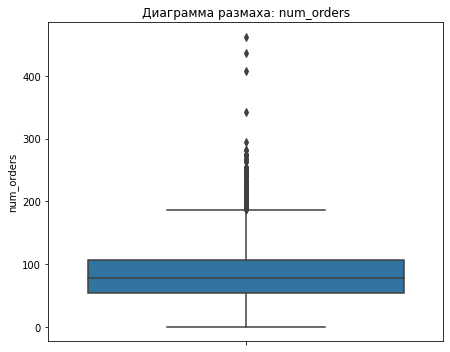

In [16]:
# Создаем визуализатор
viz_taxi = Visualizer(df_taxi.data)

# Строим ящик с усами по признакам с непрерывным характером значений
viz_taxi.boxplot(y=['num_orders'])

Выбросы в пределах разумного, оставим их без изменений

### Диаграммы распределения

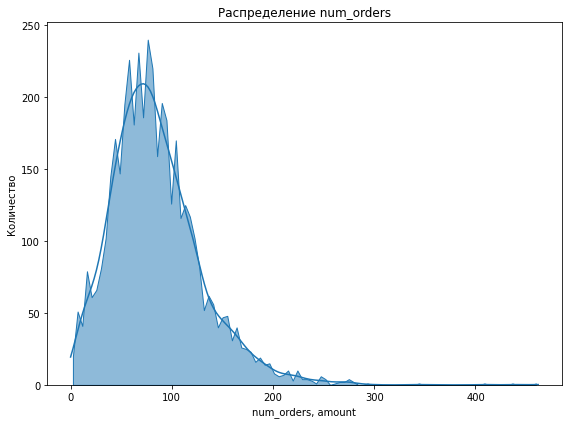

In [17]:
# Строим график распределения
viz_taxi.histplot(x=['num_orders'], measurement=['amount'])

#### Проверка на нормальность распределения

In [18]:
# Проверим распределение на нормальность с помощью теста
stat, p = normaltest(df_taxi.data['num_orders'])
if p < 0.05:
    print(f"Признак не имеет нормального распределения")
else:
    print(f"Признак имеет нормальное распределение")

Признак не имеет нормального распределения


#### Комментарии к диаграмме распределения

* Признак `num_orders` не имеет нормального распределения
* Пиковое количество наблюдений достигается в районе 90 заказов в час, после чего наблюдается спад

### Тренды и сезонность

In [19]:
# Подготовим функцию для вывода графиков сезонности, тренда, шумов
def decomp(data: Union[pd.Series, int], resample_freq: str, period: int):
    # Подготовим данные (сделаем ресэмплирование по дням)
    data = data.resample(resample_freq).sum()
    
    # Строим график тренда, сезонности и остатков
    decomposed = seasonal_decompose(data, period=period)
    trend = decomposed.trend.dropna()
    
    # Параметры графика
    plt.figure(figsize=(6, 8))
    
    # Тренд
    plt.subplot(311)
    plt.plot(trend, label='Trend (из декомпозиции)', color='blue')

    # 4. Добавляем линию линейного тренда (регрессия)
    x = np.arange(len(trend))
    coef = np.polyfit(x, trend, 1)   # степень 1 — линейная аппроксимация
    trend_line = np.poly1d(coef)(x)
    
    plt.plot(trend.index, trend_line, color='red', linestyle='--', label='Линия линейного тренда')
    plt.xticks(rotation=30, ha='right')

    # Сезонность
    plt.subplot(312)
    decomposed.seasonal.plot(ax=plt.gca())
    plt.title('Seasonality')
    
    # Остатки
    plt.subplot(313)
    decomposed.resid.plot(ax=plt.gca())
    plt.title('Residuals')

    # Выводим график на экран
    plt.tight_layout()
    plt.show()

In [20]:
# Подготовим функцию для выполнения теста Дики-Фуллера
def adf_test(series, title=''):
    """
    Выполняет тест Дики-Фуллера и выводит результаты с интерпретацией.
    
    series: pd.Series — временной ряд (например, df['num_orders'])
    title:  str — заголовок (опционально)
    """
    print(f'Результаты теста Дики-Фуллера: {title}')
    print('—' * 60)
    
    # Выполняем тест
    result = adfuller(series.dropna(), autolag='AIC')
    labels = ['ADF Statistic', 'p-value', '# Lags Used', '# Observations']
    out = pd.Series(result[0:4], index=labels)

    # Критические значения
    for key, value in result[4].items():
        out[f'Critical Value ({key})'] = value

    # Вывод
    print(out.to_string())
    print('—' * 60)

    adf_stat = result[0]
    p_value = result[1]
    crit_values = result[4]
    
    # Интерпретация по уровням значимости
    if adf_stat < crit_values['1%']:
        print("✅ Отвергаем H₀ на уровне 1% → ряд стационарен.")
    elif adf_stat < crit_values['5%']:
        print("✅ Отвергаем H₀ на уровне 5% → ряд стационарен.")
    elif p_value <= 0.05:
        print("✅ p-value ≤ 0.05 → ряд вероятно стационарен.")
    else:
        print("⚠️  Не отвергаем H₀ → ряд нестационарен (имеет единичный корень).")

    print()

Для оценки прогнозируемости данных построим графики тренда и сезонности

#### Суточная сезонность

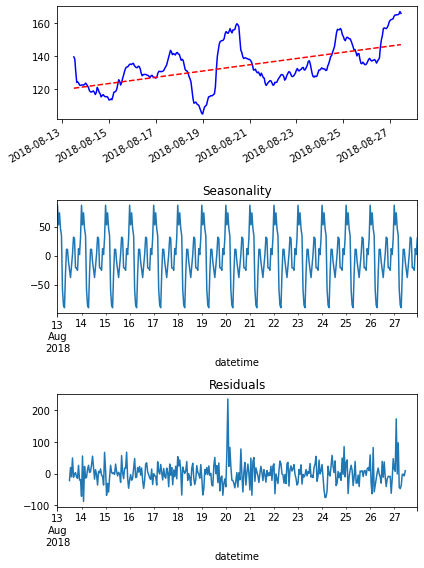

In [21]:
# Агрегируем данные
hourly_series = df_taxi.data.loc['2018-08-13':'2018-08-27']['num_orders']

# Ресэмплирование по дням
decomp(hourly_series, '1H', 24)

Комментарии к графику

* На графике Тренда за период с 13 по 27 августа наблюдается тренд роста количества заказов в сутки, что может быть связано с сезоном отпусков, когда количество полетов растет
* На графике Остатков к концу графика колебания становятся шире, что может негативно сказаться на устойчивости модели при прогнозировании

#### Проверка гипотезы о нестационарности ряда

* Н₀ (нулевая гипотеза): временной ряд количества заказов такси имеет единичный корень, то есть является нестационарным.
* Н₁ (альтернативная гипотеза): временной ряд количества заказов такси не имеет единичного корня, то есть является стационарным.

In [22]:
# Вызов функции
adf_test(hourly_series)

Результаты теста Дики-Фуллера: 
————————————————————————————————————————————————————————————
ADF Statistic           -5.87
p-value                  0.00
# Lags Used             17.00
# Observations         342.00
Critical Value (1%)     -3.45
Critical Value (5%)     -2.87
Critical Value (10%)    -2.57
————————————————————————————————————————————————————————————
✅ Отвергаем H₀ на уровне 1% → ряд стационарен.



Комментарии по итогам проверки гипотезы

* Так как p-value (0.03) < 0.05 и ADF-статистика < критического значения на уровне 5 %, нулевая гипотеза H₀ о нестационарности ряда **отвергается**.
* Следовательно, временной ряд количества заказов такси можно считать **стационарным** на уровне значимости 5 % (но не на более строгом уровне 1 %).

#### Недельная сезонность

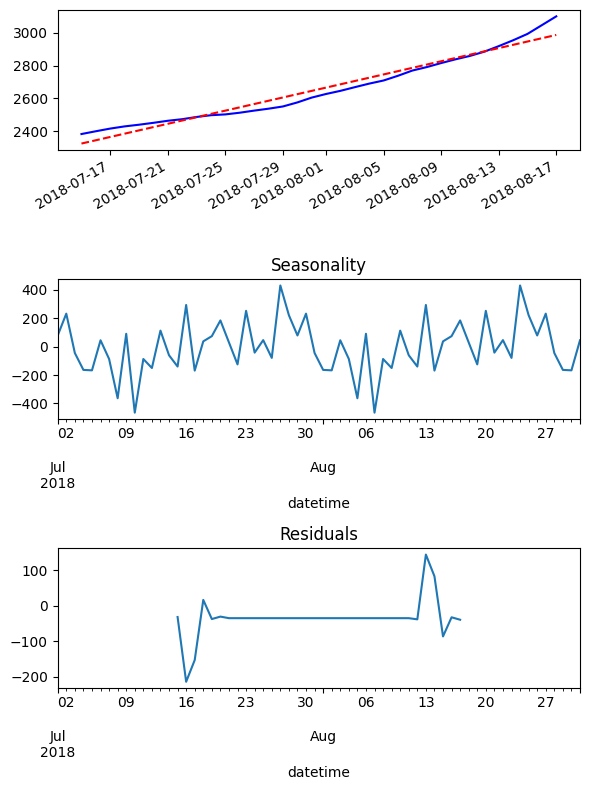

In [23]:
# Агрегируем данные
daily_series = df_taxi.data.loc['2018-07-01':'2018-08-31']['num_orders'].resample('1D').sum()

# Ресэмплирование по дням
decomp(daily_series, '1D', 28)

Комментарии к графику

* На графике Тренда наблюдается тренд роста количества заказов к лету, что наверняка связано с сезоном отпусков, когда количество полетов растет
* На графике Остатков к концу графика колебания становятся шире, что может негативно сказаться на устойчивости модели при прогнозировании

#### Проверка гипотезы о нестационарности ряда

* Н₀ (нулевая гипотеза): временной ряд количества заказов такси имеет единичный корень, то есть является нестационарным.
* Н₁ (альтернативная гипотеза): временной ряд количества заказов такси не имеет единичного корня, то есть является стационарным.

In [24]:
# Вызов функции
adf_test(daily_series)

Результаты теста Дики-Фуллера: 
————————————————————————————————————————————————————————————
ADF Statistic           1.60
p-value                 1.00
# Lags Used             7.00
# Observations         54.00
Critical Value (1%)    -3.56
Critical Value (5%)    -2.92
Critical Value (10%)   -2.60
————————————————————————————————————————————————————————————
⚠️  Не отвергаем H₀ → ряд нестационарен (имеет единичный корень).



Комментарии по итогам проверки гипотезы

* Так как p-value (1.00) > 0.05 и ADF-статистика > критического значения, нулевая гипотеза H₀ о нестационарности ряда **НЕ отвергается**.
* Следовательно, временной ряд количества заказов такси можно считать **НЕстационарным**

## Корреляционный анализ

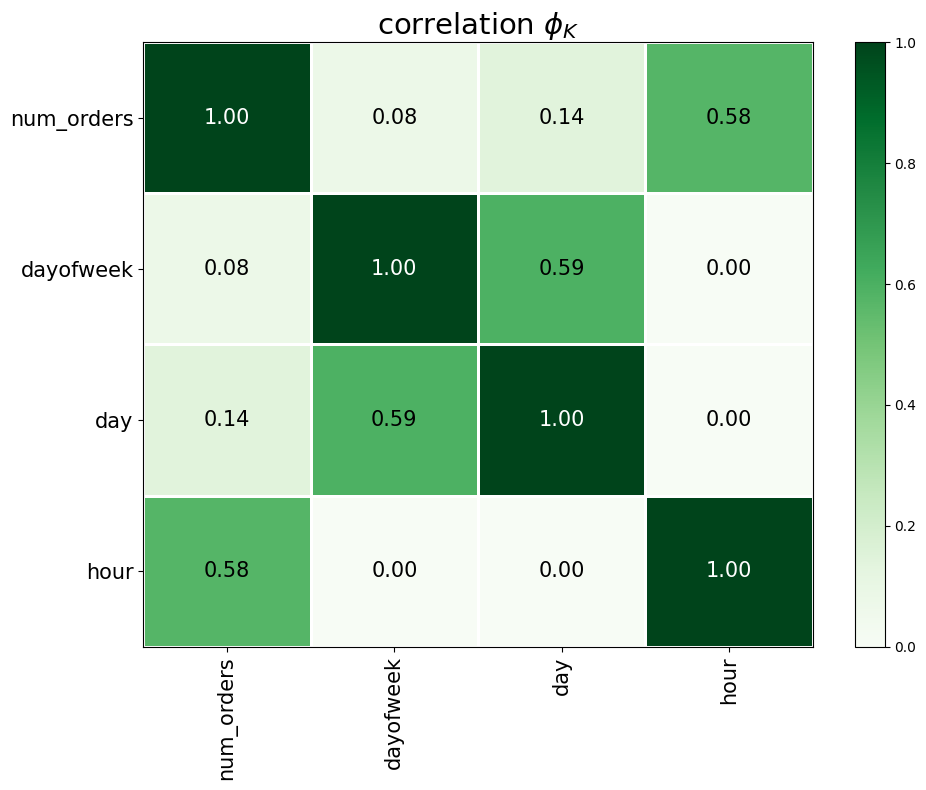

In [25]:
# Создаём список с наименованиями непрерывных признаков
interval_cols = ['num_orders']

# Считаем корреляции на выборке
phik_overview_region_first = phik_matrix(df_taxi.data[['hour', 'day', 'dayofweek', 'num_orders']], interval_cols=interval_cols)

# Визуализируем матрицу корреляции
plot_correlation_matrix(
    phik_overview_region_first.values,
    x_labels=phik_overview_region_first.columns,
    y_labels=phik_overview_region_first.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(10, 8)
)

### Промежуточные выводы

* Матрица корреляции показало наличие положительной корреляции между таргетом (количество заказов) и часом заказа

## Обучение моделей

In [26]:
df_taxi.print_head()

,num_orders,day,dayofweek,hour,lag_1,lag_2,rolling_mean
datetime,,,,,,,
2018-03-01 00:00:00,124,1,3,0,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,3,1,124.00,NaN,NaN
2018-03-01 02:00:00,71,1,3,2,85.00,124.00,NaN
2018-03-01 03:00:00,66,1,3,3,71.00,85.00,NaN
2018-03-01 04:00:00,43,1,3,4,66.00,71.00,NaN


### Особенности данных

* Для обучения модели оставим месяц и день недели, как признаки, как признаки, влияние которых на количество заказов можно логически и просто объяснить

* **OneHotEncoder (2 признака)**
Используется, потому что признаки **номинальные** — между категориями **нет естественного порядка**:
* `dayofweek`
* `hour`

* **Не требуется кодирование**, т.к. признак имеет числовую природу:
* `day`

### Выбор метрики

* Бизнесом определена метрика оценки качества модели - RMSE (корень из среднеквадратичной ошибки)
* RMSE - это метрика, которая измеряется в единицах целевого признака, поэтому её легче интерпретировать, чем, например, MSE
* Лучшее значение RMSE стремится к нулю
* Порог успешного значения метрики RMSE задан на уровне не больше 48 (<= 48)

### Пайплайн модели

In [27]:
# ================== 1. Разделяем выборку ==================

# Разделяем выборку на тестовую и тренировочную
train, test = train_test_split(
    df_taxi.data,
    shuffle=False,
    test_size=TEST_SIZE)

# Удаление строк с пропущенными значениями
train = train.dropna().reset_index(drop=True)

# Определение тренировочной выборки
X_train = train.drop('num_orders', axis=1)
y_train = train['num_orders']

# Определение тестовой выборки
X_test = test.drop('num_orders', axis=1)
y_test = test['num_orders']

# ================== 2. Определяем признаки ==================

# Создаем списки с названиями признаков
ohe_columns = ['dayofweek', 'hour']

# ================== 3. Пайплайн обработки ==================

# OHE пайплайн
ohe_pipe = Pipeline([
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse=False))
                    ])

# Создаём общий пайплан для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns)],
    remainder='passthrough'
)

# ================== 4. Финальный пайплайн ==================

# Создаём итоговый пайплан: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('model', LinearRegression())
])

# ================== 5. Сетка параметров ==================

param_grid = [

    # словарь для модели DecisionTreeRegressor()
    {
        'model': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'model__max_depth': [None, 3, 5, 7, 9, 11],
        'model__min_samples_leaf': [1, 2, 3, 4, 5],
        'model__max_features': [None, 1, 2, 3, 5]
    },

    # словарь для модели LightGBM()
    {
        'model': [LGBMRegressor(random_state=RANDOM_STATE)],
        'model__n_estimators': [100, 200],       # количество деревьев
        'model__learning_rate': [0.05, 0.1],  # шаг обучения
        'model__max_depth': [3, 5, 7, -1],      # глубина деревьев, -1 = без ограничения
    },

    # CatBoost (работает и с OHE)
    {
        'model': [CatBoostRegressor(random_state=RANDOM_STATE, verbose=0)], # Без показа логов обучения
        'model__n_estimators': [200, 400],
        'model__learning_rate': [0.03, 0.1],
        'model__depth': [4, 6, 8]
    }
]

# ================== 6. RandomizedSearchCV ==================

# Инициализируем класс для подбора гиперпараметров на 10 итераций
# значение кросс-валидации 3
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid,
    n_iter=10,
    cv=TimeSeriesSplit(n_splits=5),
    scoring='neg_root_mean_squared_error',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

# Обучаем модель
randomized_search.fit(X_train, y_train)

# ================== 7. Замер статистик по всем моделям ==================

cv_results = randomized_search.cv_results_
n_models = len(cv_results['params'])

results = []

for i in range(n_models):
    # Параметры текущей модели
    params = cv_results['params'][i]
    
    # Создаем копию пайплайна и применяем параметры
    model = clone(randomized_search.estimator)
    model.set_params(**params)
    
    # Замер времени обучения
    t0 = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - t0
    
    # Замер времени предсказания на тесте
    t1 = time.time()
    y_pred = model.predict(X_test)
    predict_time = time.time() - t1
    
    # Кросс-валидация на тренировочном наборе
    cv = TimeSeriesSplit(n_splits=5)
    cv_scores = cross_val_score(model, X_train, y_train,
                                cv=cv,
                                scoring='neg_root_mean_squared_error',
                                n_jobs=-1)
    mean_rmse = np.abs(cv_scores.mean())
    
    # Сохраняем результат
    results.append({
        'model': type(model.named_steps['model']).__name__,
        'params': params,
        'train_time_sec': train_time,
        'predict_time_sec': predict_time,
        'cv_rmse': mean_rmse
    })

# Преобразуем в DataFrame и сортируем по RMSE
results_df = pd.DataFrame(results).sort_values('cv_rmse').reset_index(drop=True)
display(results_df)

/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/sklearn/utils/fixes.py:28: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import parse_version  # type: ignore
/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/sklearn/utils/fixes.py:28: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import parse_version  # type: ignore
/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/sklearn/utils/fixes.py:28: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is sla

,model,params,train_time_sec,predict_time_sec,cv_rmse
0,CatBoostRegressor,"{'model__n_estimators': 200, 'model__learning_rate': 0.03, 'model__depth': 8, 'model': <catboost.core.CatBoostRegressor object at 0x1073bcfa0>}",0.41,0.01,26.22
1,DecisionTreeRegressor,"{'model__min_samples_leaf': 5, 'model__max_features': 3, 'model__max_depth': None, 'model': DecisionTreeRegressor(max_depth=11, max_features=3, min_samples_leaf=2, random_state=42)}",0.01,0.00,30.15
2,DecisionTreeRegressor,"{'model__min_samples_leaf': 2, 'model__max_features': 3, 'model__max_depth': None, 'model': DecisionTreeRegressor(max_depth=11, max_features=3, min_samples_leaf=2, random_state=42)}",0.01,0.00,31.59
3,DecisionTreeRegressor,"{'model__min_samples_leaf': 5, 'model__max_features': 1, 'model__max_depth': 9, 'model': DecisionTreeRegressor(max_depth=11, max_features=3, min_samples_leaf=2, random_state=42)}",0.01,0.00,33.50
4,DecisionTreeRegressor,"{'model__min_samples_leaf': 1, 'model__max_features': 3, 'model__max_depth': 11, 'model': DecisionTreeRegressor(max_depth=11, max_features=3, min_samples_leaf=2, random_state=42)}",0.01,0.00,33.53
5,DecisionTreeRegressor,"{'model__min_samples_leaf': 2, 'model__max_features': 3, 'model__max_depth': 11, 'model': DecisionTreeRegressor(max_depth=11, max_features=3, min_samples_leaf=2, random_state=42)}",0.01,0.00,33.76
6,DecisionTreeRegressor,"{'model__min_samples_leaf': 1, 'model__max_features': 1, 'model__max_depth': 3, 'model': DecisionTreeRegressor(max_depth=11, max_features=3, min_samples_leaf=2, random_state=42)}",0.01,0.00,35.28
7,DecisionTreeRegressor,"{'model__min_samples_leaf': 5, 'model__max_features': 3, 'model__max_depth': 9, 'model': DecisionTreeRegressor(max_depth=11, max_features=3, min_samples_leaf=2, random_state=42)}",0.01,0.00,35.40
8,DecisionTreeRegressor,"{'model__min_samples_leaf': 3, 'model__max_features': 3, 'model__max_depth': 5, 'model': DecisionTreeRegressor(max_depth=11, max_features=3, min_samples_leaf=2, random_state=42)}",0.01,0.00,37.91
9,DecisionTreeRegressor,"{'model__min_samples_leaf': 1, 'model__max_features': 5, 'model__max_depth': 3, 'model': DecisionTreeRegressor(max_depth=11, max_features=3, min_samples_leaf=2, random_state=42)}",0.01,0.00,38.27


* Опираясь на планку метрики RMSE в 48, по ней проходят все 10 моделей, среди них есть CatBoostRegressor и DecisionTreeRegressor
* Далее из этих моделей выберем лучшую по метрике RMSE - это CatBoostRegressor с следующими показателями с RMSE: 26.22

### Предсказание лучшей модели

In [28]:
# ================== 8. Оценка на тестовой выборке ==================

# Берём лучшую модель
best_model = randomized_search.best_estimator_

# Делаем предсказания на тестовой выборке
y_pred = best_model.predict(X_test)

# Считаем RMSE на тесте
rmse_test = mean_squared_error(y_test, y_pred, squared=False)
print(f'RMSE лучшей модели на тестовой выборке: {rmse_test:.0f}')

RMSE лучшей модели на тестовой выборке: 46


### Анализ остатков лучшей модели

Среднее остатка: 21
Стандартное отклонение остатков: 41
Минимум: -72
Максимум: 232


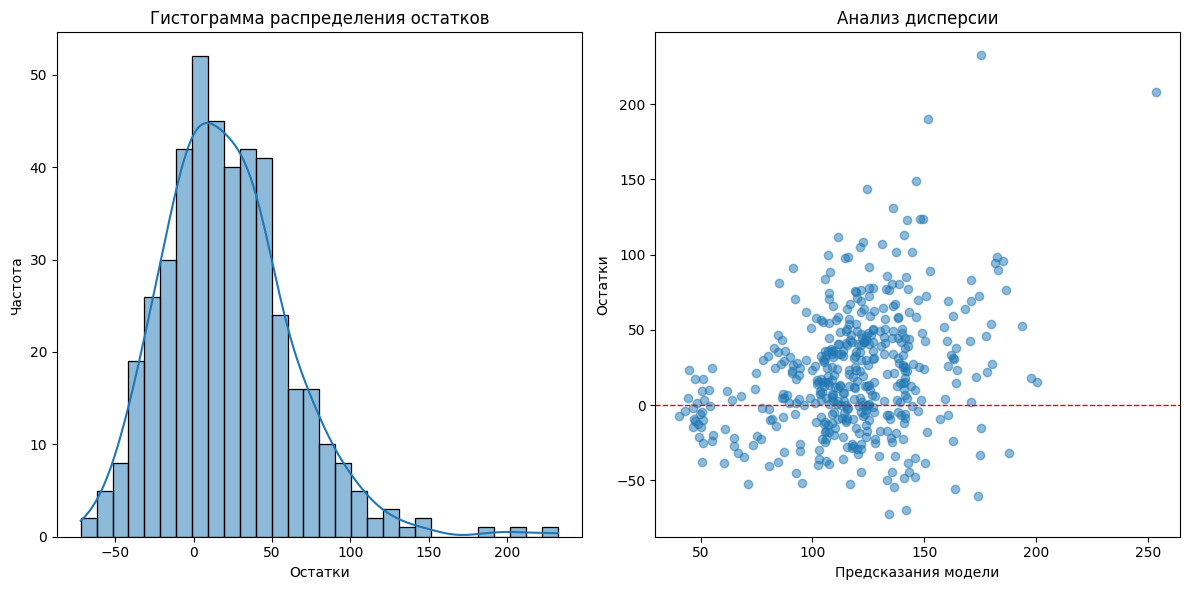

In [29]:
# 1. Рассчитаем остатки
residuals = y_test.values - y_pred

# 2. Статистики остатков
print("Среднее остатка:", round(np.mean(residuals)))
print("Стандартное отклонение остатков:", round(np.std(residuals)))
print("Минимум:", round(np.min(residuals)))
print("Максимум:", round(np.max(residuals)))

# 3. Визуализация
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Гистограмма распределения остатков
sns.histplot(residuals, bins=30, kde=True, ax=axes[0])
axes[0].set_title('Гистограмма распределения остатков')
axes[0].set_xlabel('Остатки')
axes[0].set_ylabel('Частота')

# Диаграмма рассеяния остатков против предсказаний
axes[1].scatter(y_pred, residuals, alpha=0.5)
axes[1].axhline(0, color='red', linestyle='--', linewidth=1)
axes[1].set_xlabel('Предсказания модели')
axes[1].set_ylabel('Остатки')
axes[1].set_title('Анализ дисперсии')

plt.tight_layout()
plt.show()


### Визуализация предсказаний модели

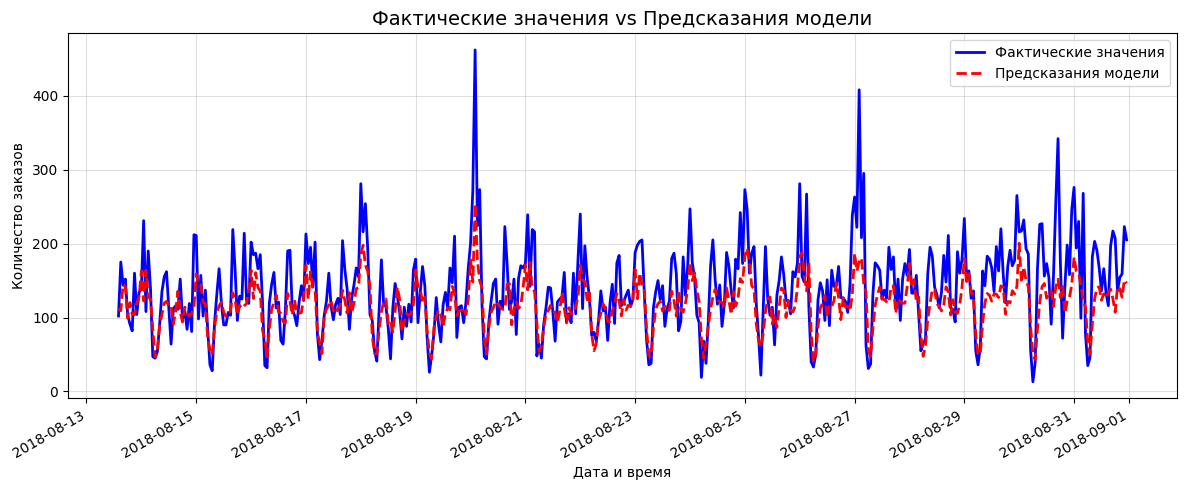

In [30]:
# y_test и y_pred — это твои реальные и предсказанные значения
plt.figure(figsize=(12, 5))
plt.plot(y_test.index, y_test, label='Фактические значения', color='blue', linewidth=2)
plt.plot(y_test.index, y_pred, label='Предсказания модели', color='red', linestyle='--', linewidth=2)

plt.title('Фактические значения vs Предсказания модели', fontsize=14)
plt.xlabel('Дата и время')
plt.ylabel('Количество заказов')
plt.legend()
plt.grid(alpha=0.4)
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()

Комментарий к графику

* На графике видно, что предсказания модели (красная пунктирная линия) хорошо повторяют динамику фактических данных (синяя линия).
* Ошибки наблюдаются преимущественно в пиковых значениях, что типично для временных рядов с ярко выраженной сезонностью.

### Промежуточные выводы

* Лучшая модель по метрике RMSE — CatBoostRegressor.
* RMSE на тестовой выборке составила 46, что лучше целевого уровня, заданного бизнесом.
* Распределение остатков близко к симметричному и унимодальному, однако наблюдается лёгкое смещение вправо — модель склонна незначительно переоценивать прогнозируемые значения.
* Дисперсия остатков неравномерна: значения распределены слабо выраженным паттерном, что может указывать на некоторую нестабильность модели и зависимость точности прогноза от уровня количества заказов.
* На графике визуализации предсказаний видно, что предсказания модели (красная пунктирная линия) хорошо повторяют динамику фактических данных (синяя линия).
* Ошибки наблюдаются преимущественно в пиковых значениях, что типично для временных рядов с ярко выраженной сезонностью.

## Общий вывод

**Итоги этапа первичного анализа датасета**
* **Количество строк:** 4 416

* **Пропущенные значения:** отсутствуют

* **Необходимые преобразования:**  
  - Столбец с датами `datetime` переведен в индекс в формате `datetime` для корректной работы с временными данными (например, сортировка, фильтрация, извлечение даты и времени)
  - Проверить диапазон значений в числовом признаке `num_orders` — возможны некорректные или экстремальные значения


* **Типы данных:**  
  - **Числовые:** *num_orders* корректно заданы как `int64`

---
**Итоги этапа подготовки данных**
* Горизонт данных - период с 03-2018 по 08-2018 (каждый час каждого дня)
* Пропущенные значения отсутствуют
* Явные и неявные дубликаты не обнаружены
* Созданы дополнительные признаки для обучения модели прогнозирование заказов на час вперед:
    * 2 часа для предсказания суточного тренда
    * 24 часов для скользящего среднего - стабилизирует тренд при его наличии

---
**Итоги этапа исследовательского анализа данных**
* Медиана количества заказов 78
* Среднее значение числа заказов составляет 84, что выше медианы (78) — это указывает на наличие выбросов, увеличивающих среднее значение
* В датасете имеется наблюдение с нулем заказов. Т.к. это единственное такое значение в датасете, оставим его без изменений
* Признак `num_orders` не имеет нормального распределения
* Пиковое количество наблюдений достигается в районе 90 заказов в час, после чего наблюдается спад

**Суточная сезонность**
* На графике Тренда за период с 13 по 27 августа наблюдается тренд роста количества заказов в сутки, что может быть связано с сезоном отпусков, когда количество полетов растет
* На графике Остатков к концу графика колебания становятся шире, что может негативно сказаться на устойчивости модели при прогнозировании
* Так как p-value (0.03) < 0.05 и ADF-статистика < критического значения на уровне 5 %, нулевая гипотеза H₀ о нестационарности ряда **отвергается**.
* Следовательно, временной ряд количества заказов такси можно считать **стационарным** на уровне значимости 5 % (но не на более строгом уровне 1 %).

**Недельная сезонность**
* На графике Тренда наблюдается тренд роста количества заказов к лету, что наверняка связано с сезоном отпусков, когда количество полетов растет
* На графике Остатков к концу графика колебания становятся шире, что может что может негативно сказаться на устойчивости модели при прогнозировании
* Так как p-value (1.00) > 0.05 и ADF-статистика > критического значения, нулевая гипотеза H₀ о нестационарности ряда **НЕ отвергается**.
* Следовательно, временной ряд количества заказов такси можно считать **НЕстационарным**

---
**Итоги обучения моделей**

**Постановка задачи**
* Бизнесом определена метрика оценки качества модели - RMSE (корень из среднеквадратичной ошибки)
* Порог успешного значения метрики RMSE задан на уровне не больше 48 (<= 48)

---
**Отбор признаков для моделей**
* Для обучения модели оставили час, день, день недели, как признаки, влияние которых на количество заказов можно логически и просто объяснить

* **OneHotEncoder (2 признака)**
Используется, потому что признаки **номинальные** — между категориями **нет естественного порядка**:
* `dayofweek`
* `hour`

* **Не требуется кодирование**, т.к. признак имеет числовую природу:
* `day`

---
**Обучение моделей**
* Построены модели CatBoostRegressor и DecisionTreeRegressor
* Далее из этих моделей выбрана CatBoostRegressor как лучшая по метрике RMSE на уровне 26 (обучающая выборка)
* RMSE на тестовой выборке составила 46, что лучше целевого уровня, заданного бизнесом

**Анализ лучшей модели**
* Распределение остатков близко к симметричному и унимодальному, однако наблюдается лёгкое смещение вправо — модель склонна незначительно переоценивать прогнозируемые значения
* Дисперсия остатков неравномерна: значения распределены слабо выраженным паттерном, что может указывать на некоторую нестабильность модели и зависимость точности прогноза от уровня количества заказов
* На графике визуализации предсказаний видно, что предсказания модели (красная пунктирная линия) хорошо повторяют динамику фактических данных (синяя линия).
* Ошибки наблюдаются преимущественно в пиковых значениях, что типично для временных рядов с ярко выраженной сезонностью.